# Exploration des partis et leur évolution dans le temps 

Dans ce carnet est proposée une exploration des partis de la population Wikidata retenue.

On essayera de prendre connaissance des liens entre les noms des partis, le genre et les générations

In [38]:
### Librairie à installer dans l'environnement conda
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats


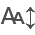

In [40]:
### https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)


In [41]:
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder

In [42]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [43]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

## Créer une nouvelle table dans la base de données SQLite

In [44]:
### Se connecter à la base de données dans laquelle on va insérer
# le résultat de la requête SPARQL
cn = sql.connect('../../data/conseil_national_import.db')
cn

In [45]:
### On récupère tout la table et on la met dans la list 'l'
cur = cn.cursor()
l = cur.execute("SELECT * FROM wdt_partis ").fetchall()

In [46]:
### On transforme la liste en DataFrame
df_p = pd.DataFrame(l, columns=['id', 'parti_code', 'parti_uri'],)
df_p = df_p.set_index('id',drop=True)
df_p.head()

,parti_code,parti_uri
id,,
0,FN,http://www.wikidata.org/entity/Q672926
1,CF,http://www.wikidata.org/entity/Q684909
2,NeF,http://www.wikidata.org/entity/Q13142801
3,PRD,http://www.wikidata.org/entity/Q659461
4,PS,http://www.wikidata.org/entity/Q303745


In [47]:
### Vérifier que les données ont été importées correctement
cur = cn.cursor()
l = cur.execute("SELECT * FROM wdt_partis limit 3").fetchall()
### On a mis le résultat de la requête SQL 
# dans une liste 'l' qu'on affiche avec une boucle 'for'
# dans le cadre d'une 'list comprehension'
a = [print(e) for e in l]

(0, 'FN', 'http://www.wikidata.org/entity/Q672926')
(1, 'CF', 'http://www.wikidata.org/entity/Q684909')
(2, 'NeF', 'http://www.wikidata.org/entity/Q13142801')


## Prendre connaissance des occupations - besoin de lier la table personne à la table parti

In [48]:
cn = sql.connect('../../data/conseil_national_import.db')

In [49]:
q="""
   SELECT parti_uri, parti_code, COUNT(*) as effectif
FROM 
    wdt_personnes wp
JOIN 
    wdt_personnes_partis wpp   ON wp.id = wpp.fk_personne_id
JOIN 
    wdt_partis wp2  ON wp2.id = wpp.fk_parti_id
GROUP BY parti_uri , parti_code
ORDER BY effectif DESC
"""
cur = cn.cursor()
r = cur.execute(q).fetchall()
rdf = pd.DataFrame(r,columns=['uri', 'code', 'freq'])
rdf.head()

,uri,code,freq
0,http://www.wikidata.org/entity/Q659461,PRD,293
1,http://www.wikidata.org/entity/Q303745,PS,209
2,http://www.wikidata.org/entity/Q385258,UDC,145
3,http://www.wikidata.org/entity/Q659739,Verts,64
4,http://www.wikidata.org/entity/Q202638,PLR,52


In [50]:
rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   uri     35 non-null     object
 1   code    35 non-null     object
 2   freq    35 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 972.0+ bytes


In [51]:
### Le nombre de partis différents: noter qu'il y des répétitions
## et inconsistances dans les données de Wikidata

q="""
SELECT COUNT(*)
FROM wdt_partis
"""
cur = cn.cursor()
r = cur.execute(q).fetchone()
print('Nombre de partis différents:' , r[0])

Nombre de partis différents: 35


In [52]:
## Vérifier que le DataFrame rdf contient le même nombre de modalités
print(len(rdf))

35


In [53]:
print(rdf)

                                          uri     code  freq
0      http://www.wikidata.org/entity/Q659461      PRD   293
1      http://www.wikidata.org/entity/Q303745       PS   209
2      http://www.wikidata.org/entity/Q385258      UDC   145
3      http://www.wikidata.org/entity/Q659739    Verts    64
4      http://www.wikidata.org/entity/Q202638      PLR    52
5      http://www.wikidata.org/entity/Q667785      PLS    26
6      http://www.wikidata.org/entity/Q550295  ALL_IND    25
7      http://www.wikidata.org/entity/Q545900      PVL    22
8   http://www.wikidata.org/entity/Q100934025       LC    15
9      http://www.wikidata.org/entity/Q477228      PAI    13
10     http://www.wikidata.org/entity/Q151768      PBD    12
11     http://www.wikidata.org/entity/Q667718      PEV     9
12     http://www.wikidata.org/entity/Q660046       DS     7
13     http://www.wikidata.org/entity/Q661771      PST     7
14     http://www.wikidata.org/entity/Q668101     lega     7
15    http://www.wikidat

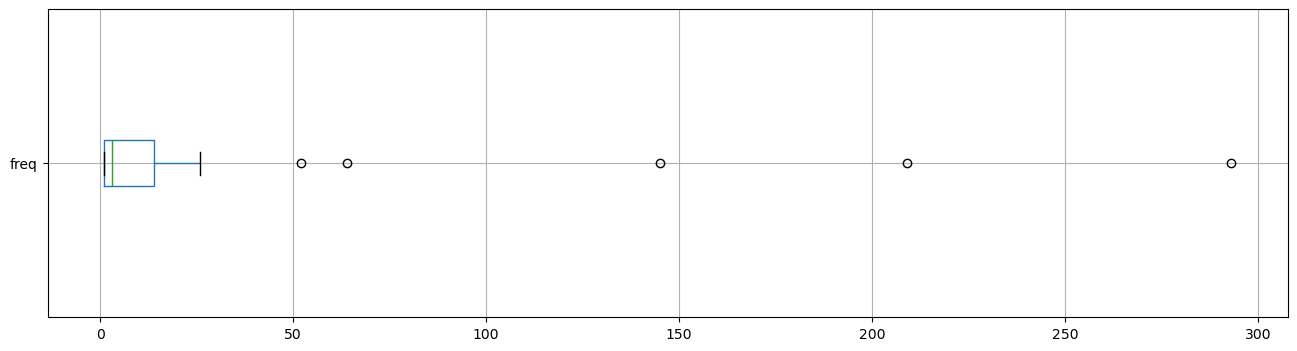

In [54]:
### Disribution des partis
## On observe une masse de partis avec peu d'effectifs,
# et quelques partis très courants.
# Ils sont représentées en tant que valeurs extrêmes
rdf.boxplot(column=['freq'], vert=False, figsize=(16,4))
plt.show()


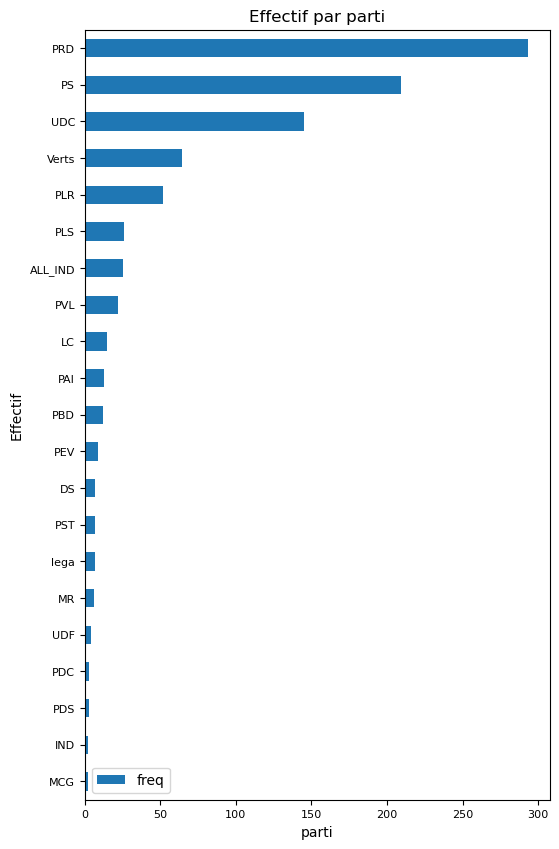

In [55]:
### Représentation graphique des effectifs

ax = rdf[(rdf['freq']>1) & (rdf['freq'] < 2000)].sort_values(by='freq', ascending=True).plot(x='code', y='freq', 
                 kind='barh', fontsize=8, figsize=(6, 10)) # ,rot=5


#max_xticks = 20
#xloc = plt.MaxNLocator(max_xticks)
#ax.xaxis.set_major_locator(xloc)

plt.ylabel('Effectif')
plt.xlabel('parti')
plt.title('Effectif par parti')

# Doc.: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('images/effectif_par_parti.jpg', bbox_inches='tight',
                       pad_inches=0.2)
plt.show()

In [56]:
q="""
SELECT *
FROM wdt_partis
"""
cur = cn.cursor()
r = cur.execute(q).fetchall()
[e for e in r][:3]

[(0, 'FN', 'http://www.wikidata.org/entity/Q672926'),
 (1, 'CF', 'http://www.wikidata.org/entity/Q684909'),
 (2, 'NeF', 'http://www.wikidata.org/entity/Q13142801')]

In [57]:
print(len(df_p))

35


### Ajouter le genre

In [58]:
p="""
SELECT 
    wpp.fk_parti_id,
    wp.nom_prenom AS nom_prenom,
    wp2.parti_code AS parti_code,
    wg.genre_code AS genre_code,
    wp2.parti_uri AS parti_uri,
    wp.annee_naissance AS annee_naissance
FROM 
    wdt_personnes wp
JOIN 
    wdt_personnes_partis wpp ON wp.id = wpp.fk_personne_id
JOIN 
    wdt_partis wp2 ON wp2.id = wpp.fk_parti_id
JOIN 
    wdt_genre wg ON wp.fk_genre_id = wg.id
ORDER BY 
    wp.annee_naissance;
"""


In [59]:
cur = cn.cursor()
r = cur.execute(p).fetchall()
[e for e in r][:3]

[(0,
  'Robert Tobler',
  'FN',
  'M',
  'http://www.wikidata.org/entity/Q672926',
  1901),
 (1,
  'Robert Tobler',
  'CF',
  'M',
  'http://www.wikidata.org/entity/Q684909',
  1901),
 (2,
  'Robert Tobler',
  'NeF',
  'M',
  'http://www.wikidata.org/entity/Q13142801',
  1901)]

In [60]:
### On transforme la liste en DataFrame
df_p = pd.DataFrame(r, columns=['fk_parti_id', 'nom_prenom',
                       'parti_code', 'genre_code', 'parti_uri', 'annee_naissance'])
df_p = df_p.set_index('fk_parti_id',drop=True)
df_p.head()

,nom_prenom,parti_code,genre_code,parti_uri,annee_naissance
fk_parti_id,,,,,
0,Robert Tobler,FN,M,http://www.wikidata.org/entity/Q672926,1901
1,Robert Tobler,CF,M,http://www.wikidata.org/entity/Q684909,1901
2,Robert Tobler,NeF,M,http://www.wikidata.org/entity/Q13142801,1901
3,Hans Fischer,PRD,M,http://www.wikidata.org/entity/Q659461,1901
4,Franz Landolt,PS,M,http://www.wikidata.org/entity/Q303745,1901


### Ajouter les périodes

In [61]:
df_p['annee_naissance'] = df_p['annee_naissance'].astype(int)
df_p = df_p[df_p['annee_naissance'] < 2001].copy(deep=True)

In [62]:
print(min(df_p['annee_naissance']),max(df_p['annee_naissance']))

1901 1994


In [63]:
l_per = [1901, 1915, 1930, 1946, 1976, 1997]

In [64]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_p['periodes'] = pd.cut(df_p['annee_naissance'], l_per, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periodes'] = df_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,nom_prenom,parti_code,genre_code,parti_uri,annee_naissance,periodes
fk_parti_id,,,,,,
0,Robert Tobler,FN,M,http://www.wikidata.org/entity/Q672926,1901,1901-1914
1,Robert Tobler,CF,M,http://www.wikidata.org/entity/Q684909,1901,1901-1914
2,Robert Tobler,NeF,M,http://www.wikidata.org/entity/Q13142801,1901,1901-1914


### regroupement des partis par orientations

In [65]:
def orientation_code(o_uri):
    if o_uri == 'http://www.wikidata.org/entity/Q303745':
        # PS
        a = 'gauche'
    elif o_uri =='http://www.wikidata.org/entity/Q385258':
        # UDC
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q13850128':
        # PRD
        a = 'droite_liberale'
    elif o_uri =='http://www.wikidata.org/entity/Q659461':
        # PDC
        a = 'centre'
    elif o_uri =='http://www.wikidata.org/entity/Q659739':
        # Les Verts
        a = 'ecologiste'
    elif o_uri =='http://www.wikidata.org/entity/Q202638':
        # PLR
        a = 'droite_liberale'
    elif o_uri =='http://www.wikidata.org/entity/Q667785':
        # PLS
        a = 'droite_liberale'
    elif o_uri =='http://www.wikidata.org/entity/Q550295':
        # alliance des indépendants
        a = 'independant'
    elif o_uri =='http://www.wikidata.org/entity/Q545900':
        # PVL
        a = 'droite_liberale'
    elif o_uri =='http://www.wikidata.org/entity/Q100934025':
        # le centre
        a = 'centre'
    elif o_uri =='http://www.wikidata.org/entity/Q151768':
        # parti bourgeois démocrate
        a = 'centre'
    elif o_uri =='http://www.wikidata.org/entity/Q477228':
        # parti des paysans et artisans indépendants
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q667718':
        # parti évangélique suisse
        a = 'droite_conservatrice'
    elif o_uri =='http://www.wikidata.org/entity/Q661771':
        # parti suisse du travail
        a = 'extreme_gauche'
    elif o_uri =='http://www.wikidata.org/entity/Q660046':
        # démocrates suisse ou action nationale
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q668101':
        # ligue des Tessinois
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q2145393':
        # mouvement républicain
        a = 'droite_conservatrice'
    elif o_uri =='http://www.wikidata.org/entity/Q667836':
        # union démocratique fédérale
        a = 'droite_conservatrice'
    elif o_uri =='http://www.wikidata.org/entity/Q681843':
        # parti démocrate suisse
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q667725':
        # parti chrétien social
        a = 'centre'
    elif o_uri =='http://www.wikidata.org/entity/Q663580':
        # mouvement citoyens genevois
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q362949':
        # organisation progressistes de Suisse
        a = 'extreme_gauche'
    elif o_uri =='http://www.wikidata.org/entity/Q327591':
        # indépendant
        a = 'independant'
    elif o_uri =='http://www.wikidata.org/entity/Q13124':
        # parti libéral démocrate
        a = 'droite_liberale'
    elif o_uri =='http://www.wikidata.org/entity/Q684909':
        # collection fédérale Eidgenössische Sammlung
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q677491':
        # mouvement socio-libéral
        a = 'droite_conservatrice'
    elif o_uri =='http://www.wikidata.org/entity/Q672946':
        # parti suisse de la liberté
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q672926':
        # front national
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q3366732':
        # parti socialiste autonome
        a = 'gauche'
    elif o_uri =='http://www.wikidata.org/entity/Q3366188':
        # parti chrétien-social indépendant
        a = 'droite_conservatrice'
    elif o_uri =='http://www.wikidata.org/entity/Q286683':
        # solidaritéS
        a = 'extreme_gauche'
    elif o_uri =='http://www.wikidata.org/entity/Q255650':
        # la Gauche alternative linke
        a = 'gauche'
    elif o_uri =='http://www.wikidata.org/entity/Q20012603':
        # ensemble à gauche
        a = 'extreme_gauche'
    elif o_uri =='http://www.wikidata.org/entity/Q13142801':
        # Neue Front
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q1254507':
        # alliance verte et sociale bernoise, grünes bündnis
        a = 'ecologiste'
    elif o_uri =='http://www.wikidata.org/entity/Q1186111':
        # demokratisch-soziale partei
        a = 'centre'
    elif o_uri =='http://www.wikidata.org/entity/Q1084149':
        # parti chrétien-social d'obwald
        a = 'droite_conservatrice'
    elif o_uri =='http://www.wikidata.org/entity/Q10594788':
        # action nationale pour le peuple et la patrie
        a = 'extreme_droite'
    else :
        # orientation autre
        a = 'A'
    return a 

In [66]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p['orientation_code'] = df_p.apply(lambda x: orientation_code(x['parti_uri']), axis=1)

In [67]:
### On inspecte les cinq premières lignes qui ont la valeur 'P' = populisme
df_p[df_p['orientation_code']=='populisme'][:5]

,nom_prenom,parti_code,genre_code,parti_uri,annee_naissance,periodes,orientation_code
fk_parti_id,,,,,,,


### tableau de contingence

In [68]:
### La fonction pivot_table produit un tableau de contingence
## Au centre du tableau se trouvent les effectifs conjoints, 
## aux bords les effectifs marginaux qui correspondent 
## aux distributions indépendantes des variables

X = "orientation_code"  # "0"
Y = "periodes"

df_p_parti_generation = df_p[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
df_p_parti_generation

C:\Users\LZender\AppData\Local\Temp\ipykernel_19120\923661542.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_p_parti_generation = df_p[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)


orientation_code,centre,droite_conservatrice,droite_liberale,ecologiste,extreme_droite,extreme_gauche,gauche,independant,Total
periodes,,,,,,,,,
1901-1914,43,1,7,0,17,1,28,9,106
1915-1929,73,3,6,1,22,3,31,8,147
1930-1945,84,4,7,7,32,0,35,9,178
1946-1975,116,13,69,45,93,5,97,1,439
1976-1996,7,1,12,12,18,0,20,0,70
Total,323,22,101,65,182,9,211,27,940


In [69]:
### Fréquence conjointe et fréquence marginale (proportion par rapport au total)

df_p_parti_generation_frequence = np.round(df_p_parti_generation*100/df_p_parti_generation.iloc[-1,-1],1)
df_p_parti_generation_frequence

orientation_code,centre,droite_conservatrice,droite_liberale,ecologiste,extreme_droite,extreme_gauche,gauche,independant,Total
periodes,,,,,,,,,
1901-1914,4.6,0.1,0.7,0.0,1.8,0.1,3.0,1.0,11.3
1915-1929,7.8,0.3,0.6,0.1,2.3,0.3,3.3,0.9,15.6
1930-1945,8.9,0.4,0.7,0.7,3.4,0.0,3.7,1.0,18.9
1946-1975,12.3,1.4,7.3,4.8,9.9,0.5,10.3,0.1,46.7
1976-1996,0.7,0.1,1.3,1.3,1.9,0.0,2.1,0.0,7.4
Total,34.4,2.3,10.7,6.9,19.4,1.0,22.4,2.9,100.0


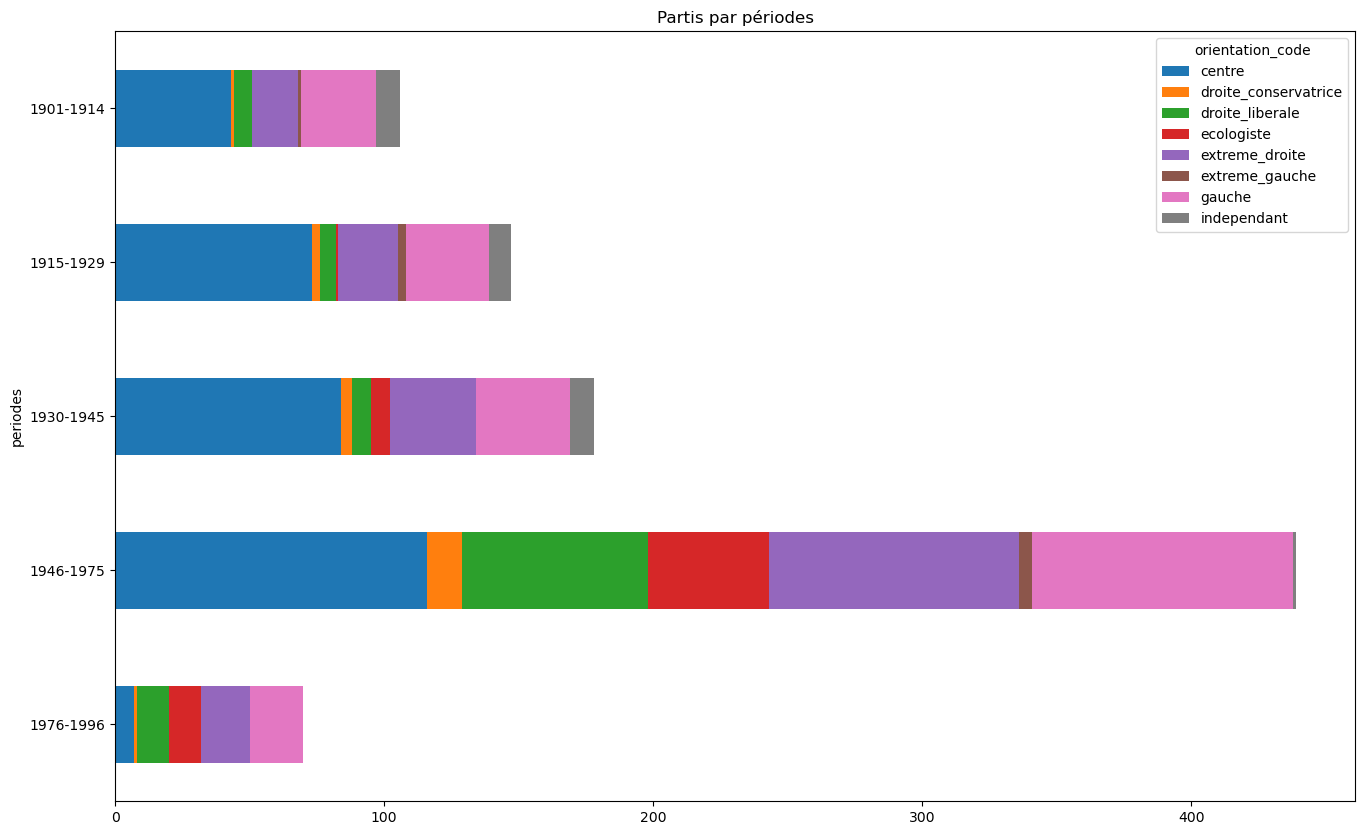

In [70]:
### Effectifs des partis par génération
g = df_p_parti_generation.iloc[:-1, :-1].sort_index(ascending=False)\
        .plot( kind='barh', stacked=True,  figsize=(16,10),  title = 'Partis par périodes')


plt.show()

In [71]:
### pourcentages des lignes
stacked_data_lignes = df_p_parti_generation.apply(lambda x: (x*100/sum(x)*2).round(2), axis=1) # axis=0
stacked_data_lignes

orientation_code,centre,droite_conservatrice,droite_liberale,ecologiste,extreme_droite,extreme_gauche,gauche,independant,Total
periodes,,,,,,,,,
1901-1914,40.57,0.94,6.60,0.00,16.04,0.94,26.42,8.49,100.0
1915-1929,49.66,2.04,4.08,0.68,14.97,2.04,21.09,5.44,100.0
1930-1945,47.19,2.25,3.93,3.93,17.98,0.00,19.66,5.06,100.0
1946-1975,26.42,2.96,15.72,10.25,21.18,1.14,22.10,0.23,100.0
1976-1996,10.00,1.43,17.14,17.14,25.71,0.00,28.57,0.00,100.0
Total,34.36,2.34,10.74,6.91,19.36,0.96,22.45,2.87,100.0


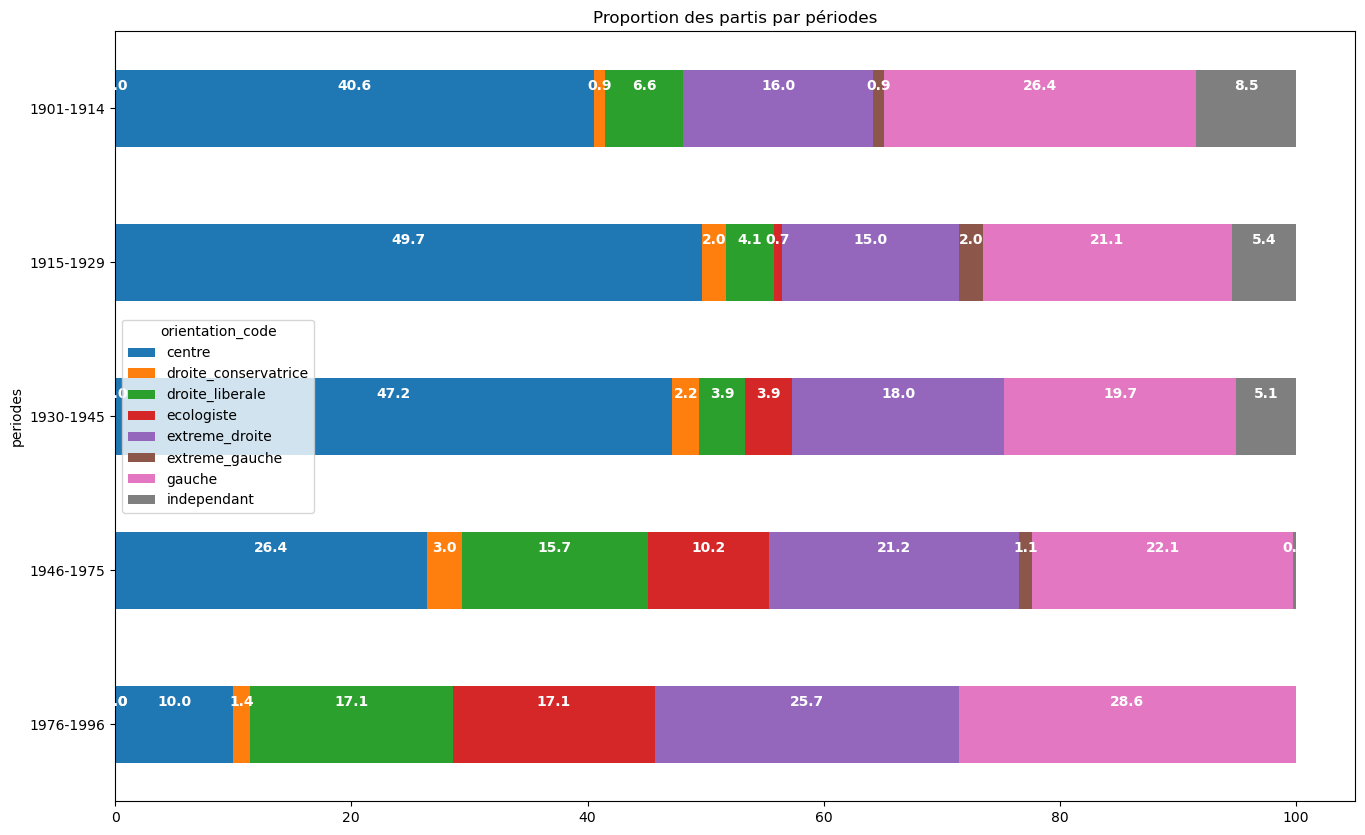

In [72]:
### https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

z = stacked_data_lignes.iloc[:-1, :-1].sort_index(ascending=False).plot(kind="barh", stacked=True, figsize=(16,10), title='Proportion des partis par périodes')

### https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
#b = [(p.get_bbox().bounds, p.get_bbox().xmin,p.get_bbox().ymin, p.get_bbox().ymax, p.get_width(), p.get_y(), p.get_height()) for p in z.patches][59]
#print(b)
for p in z.patches:
    b = p.get_bbox()
    y_value=b.y1-b.y0
    z.annotate(format(p.get_width(), '.1f'), 
                   (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   # style = 'italic',
                   weight='bold',
                   color = 'white',
                   xytext = (0, -12), 
                   textcoords = 'offset points')

# Doc.: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('images/partis_par_périodes.jpg', bbox_inches='tight',
                       pad_inches=0.2)
plt.show()

In [73]:
### https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

## pourcentages des colonnes (ou des lignes après avoir interverti les variables dans le tableau)
# axis=0 à la place de axis=1
stacked_data_cols = df_p_parti_generation.apply(lambda x: round(x*100/sum(x)*2, 2), axis=0) 
stacked_data_cols

orientation_code,centre,droite_conservatrice,droite_liberale,ecologiste,extreme_droite,extreme_gauche,gauche,independant,Total
periodes,,,,,,,,,
1901-1914,13.31,4.55,6.93,0.00,9.34,11.11,13.27,33.33,11.28
1915-1929,22.60,13.64,5.94,1.54,12.09,33.33,14.69,29.63,15.64
1930-1945,26.01,18.18,6.93,10.77,17.58,0.00,16.59,33.33,18.94
1946-1975,35.91,59.09,68.32,69.23,51.10,55.56,45.97,3.70,46.70
1976-1996,2.17,4.55,11.88,18.46,9.89,0.00,9.48,0.00,7.45
Total,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00


In [74]:
### Ajouter des valeurs pour le tri des colonnes
stacked_data_cols.loc['sort_index'] = [5,2,3,1,4,7,6,8,None]
stacked_data_cols

orientation_code,centre,droite_conservatrice,droite_liberale,ecologiste,extreme_droite,extreme_gauche,gauche,independant,Total
periodes,,,,,,,,,
1901-1914,13.31,4.55,6.93,0.00,9.34,11.11,13.27,33.33,11.28
1915-1929,22.60,13.64,5.94,1.54,12.09,33.33,14.69,29.63,15.64
1930-1945,26.01,18.18,6.93,10.77,17.58,0.00,16.59,33.33,18.94
1946-1975,35.91,59.09,68.32,69.23,51.10,55.56,45.97,3.70,46.70
1976-1996,2.17,4.55,11.88,18.46,9.89,0.00,9.48,0.00,7.45
Total,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
sort_index,5.00,2.00,3.00,1.00,4.00,7.00,6.00,8.00,NaN


In [75]:
### Interchanger les lignes avec les colonnes (=transposer) 
#  afin d'utiliser le même affichage en diagramme à barres
ts_stacked_data_cols = stacked_data_cols.transpose().sort_values(by='sort_index')
ts_stacked_data_cols

periodes,1901-1914,1915-1929,1930-1945,1946-1975,1976-1996,Total,sort_index
orientation_code,,,,,,,
ecologiste,0.00,1.54,10.77,69.23,18.46,100.0,1.0
droite_conservatrice,4.55,13.64,18.18,59.09,4.55,100.0,2.0
droite_liberale,6.93,5.94,6.93,68.32,11.88,100.0,3.0
extreme_droite,9.34,12.09,17.58,51.10,9.89,100.0,4.0
centre,13.31,22.60,26.01,35.91,2.17,100.0,5.0
gauche,13.27,14.69,16.59,45.97,9.48,100.0,6.0
extreme_gauche,11.11,33.33,0.00,55.56,0.00,100.0,7.0
independant,33.33,29.63,33.33,3.70,0.00,100.0,8.0
Total,11.28,15.64,18.94,46.70,7.45,100.0,NaN


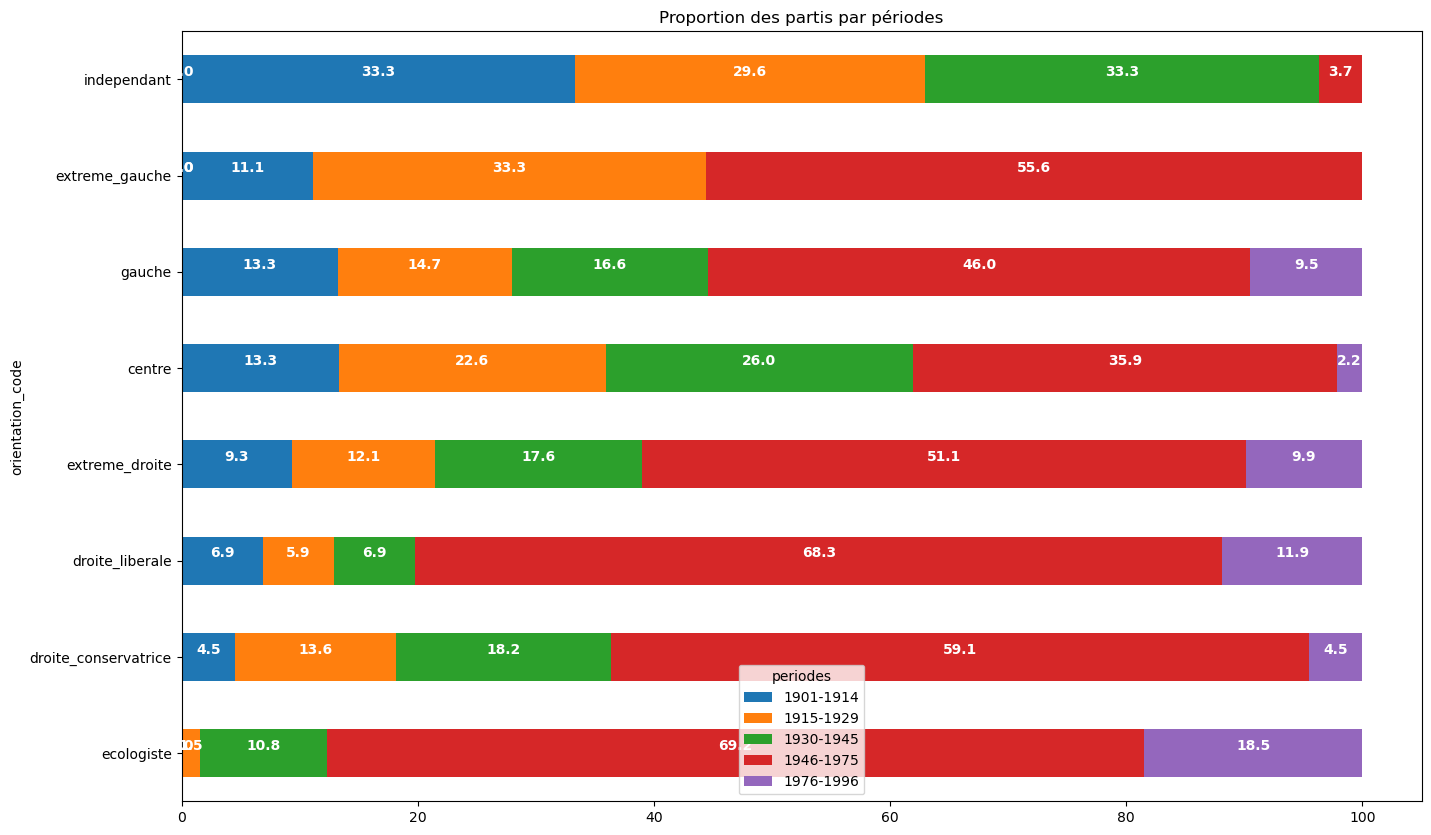

In [76]:
### https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

z = ts_stacked_data_cols.iloc[:-1, :-2].plot(kind="barh", stacked=True, figsize=(16,10), title='Proportion des partis par périodes')

### https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
#b = [(p.get_bbox().bounds, p.get_bbox().xmin,p.get_bbox().ymin, p.get_bbox().ymax, p.get_width(), p.get_y(), p.get_height()) for p in z.patches][59]
#print(b)
for p in z.patches:
    b = p.get_bbox()
    y_value=b.y1-b.y0
    z.annotate(format(p.get_width(), '.1f'), 
                   (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   # style = 'italic',
                   weight='bold',
                   color = 'white',
                   xytext = (0, -12), 
                   textcoords = 'offset points')
# Doc.: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('images/partis_par_périodes_bis.jpg', bbox_inches='tight',
                       pad_inches=0.2)
plt.show()

### Tableau théorique en cas d'indépendance

Produit des marges divisé par le total et arrondi

In [77]:
### Total général, dernière cellule de la dernière ligne
df_p_parti_generation.iat[-1,-1]

940

In [78]:
tx = df_p_parti_generation.loc[:,["Total"]]
ty = df_p_parti_generation.loc[["Total"],:]
n = df_p_parti_generation.iat[-1,-1] 

### Compute the matrix multiplication between the columns.
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dot.html
indep = tx.dot(ty) / n
#pd.options.display.float_format = '{0:3.5}'.format

# Non arrondi
print(indep)

print('\n--------------------------\n')
# Arrondi
print(indep.round(0).astype(int))


orientation_code      centre  droite_conservatrice  droite_liberale  \
periodes                                                              
1901-1914          36.423404              2.480851        11.389362   
1915-1929          50.511702              3.440426        15.794681   
1930-1945          61.163830              4.165957        19.125532   
1946-1975         150.847872             10.274468        47.169149   
1976-1996          24.053191              1.638298         7.521277   
Total             323.000000             22.000000       101.000000   

orientation_code  ecologiste  extreme_droite  extreme_gauche      gauche  \
periodes                                                                   
1901-1914           7.329787       20.523404        1.014894   23.793617   
1915-1929          10.164894       28.461702        1.407447   32.996809   
1930-1945          12.308511       34.463830        1.704255   39.955319   
1946-1975          30.356383       84.997872       

In [79]:
### Différence en effectifs entre le théorique et l'observé
#  Valeurs arrondies
### Doc. :
#   Bennani, p.30
#  https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4775616-analysez-deux-variables-qualitatives-avec-le-chi-2
ecarts = (df_p_parti_generation-indep).iloc[:-1,:-1]
## Attention : arrondi aux entiers dans l'affichage
print(ecarts.round(0).astype(int))


orientation_code  centre  droite_conservatrice  droite_liberale  ecologiste  \
periodes                                                                      
1901-1914              7                    -1               -4          -7   
1915-1929             22                     0              -10          -9   
1930-1945             23                     0              -12          -5   
1946-1975            -35                     3               22          15   
1976-1996            -17                    -1                4           7   

orientation_code  extreme_droite  extreme_gauche  gauche  independant  
periodes                                                               
1901-1914                     -4               0       4            6  
1915-1929                     -6               2      -2            4  
1930-1945                     -2              -2      -5            4  
1946-1975                      8               1      -2          -12  
1976-1996     

In [80]:
def sign(val):
    
    if val > 0:
        a = 1
    elif val < 0:
        a = -1
    else:
        a = 0    
    return a


sign(-3)

-1

In [81]:
ecarts_sign = ecarts.applymap(sign)
ecarts_sign

C:\Users\LZender\AppData\Local\Temp\ipykernel_19120\903752819.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ecarts_sign = ecarts.applymap(sign)


orientation_code,centre,droite_conservatrice,droite_liberale,ecologiste,extreme_droite,extreme_gauche,gauche,independant
periodes,,,,,,,,
1901-1914,1,-1,-1,-1,-1,-1,1,1
1915-1929,1,-1,-1,-1,-1,1,-1,1
1930-1945,1,-1,-1,-1,-1,-1,-1,1
1946-1975,-1,1,1,1,1,1,-1,-1
1976-1996,-1,-1,1,1,1,-1,1,-1


In [82]:
### Ecarts positifs et pondérés par les effectifs
### Doc. :
#   Bennani, p.31
#  https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4775616-analysez-deux-variables-qualitatives-avec-le-chi-2
ecarts_ponderes = round((df_p_parti_generation-indep)**2/indep,2)
ecarts_ponderes.iloc[:-1,:-1]

orientation_code,centre,droite_conservatrice,droite_liberale,ecologiste,extreme_droite,extreme_gauche,gauche,independant
periodes,,,,,,,,
1901-1914,1.19,0.88,1.69,7.33,0.60,0.00,0.74,11.65
1915-1929,10.01,0.06,6.07,8.26,1.47,1.80,0.12,3.38
1930-1945,8.53,0.01,7.69,2.29,0.18,1.70,0.61,2.96
1946-1975,8.05,0.72,10.10,7.06,0.75,0.15,0.02,10.69
1976-1996,12.09,0.25,2.67,10.59,1.46,0.67,1.17,2.01


In [83]:
ecarts_ponderes_sign = ecarts_ponderes.iloc[:-1,:-1] * ecarts_sign
ecarts_ponderes_sign

orientation_code,centre,droite_conservatrice,droite_liberale,ecologiste,extreme_droite,extreme_gauche,gauche,independant
periodes,,,,,,,,
1901-1914,1.19,-0.88,-1.69,-7.33,-0.60,-0.00,0.74,11.65
1915-1929,10.01,-0.06,-6.07,-8.26,-1.47,1.80,-0.12,3.38
1930-1945,8.53,-0.01,-7.69,-2.29,-0.18,-1.70,-0.61,2.96
1946-1975,-8.05,0.72,10.10,7.06,0.75,0.15,-0.02,-10.69
1976-1996,-12.09,-0.25,2.67,10.59,1.46,-0.67,1.17,-2.01


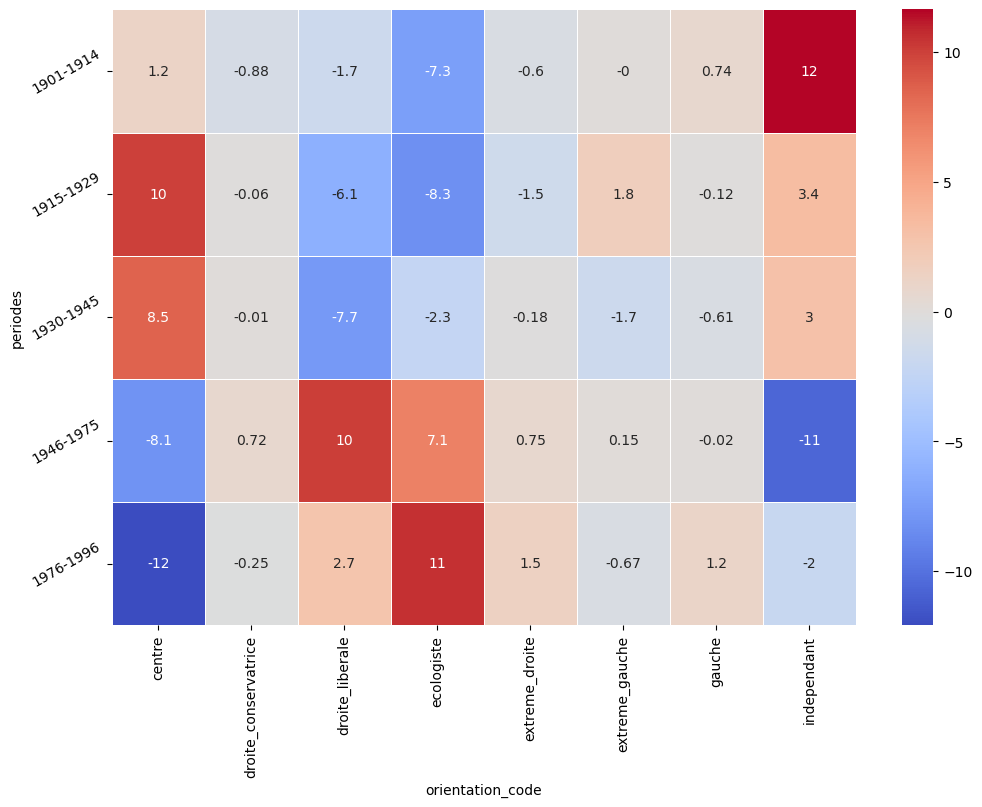

In [84]:
### Écart pondérés
tableau = ecarts_ponderes_sign

fig, ax = plt.subplots(figsize=(12,8))         
# Sample figsize in inches
g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
labels = tableau.index
p = g.set_yticklabels(labels, rotation=30)

# Doc.: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('images/partis_par_périodes_écarts_pondérés.jpg', bbox_inches='tight',
                       pad_inches=0.2)

plt.show()

In [85]:
### Degrés d'indépendance
(len(ecarts_ponderes)-1) * (len(ecarts_ponderes.columns)-1), len(ecarts_ponderes)-1,len(ecarts_ponderes.columns)-1

(40, 5, 8)

In [86]:
colonnes = ecarts_ponderes.sum()
print(colonnes)

orientation_code
centre                  39.87
droite_conservatrice     1.92
droite_liberale         28.22
ecologiste              35.53
extreme_droite           4.46
extreme_gauche           4.32
gauche                   2.66
independant             30.69
Total                    0.00
dtype: float64


In [87]:
chi_2 = ecarts_ponderes.sum().sum()
print(round(chi_2, 2))

147.67


In [88]:
statistic, p, dof, expected = stats.chi2_contingency(df_p_parti_generation)

print(statistic, p, dof)

dfe = round(pd.DataFrame(expected),1)
dfe

147.6894044447228 2.945776433773352e-14 40


,0,1,2,3,4,5,6,7,8
0,36.4,2.5,11.4,7.3,20.5,1.0,23.8,3.0,106.0
1,50.5,3.4,15.8,10.2,28.5,1.4,33.0,4.2,147.0
2,61.2,4.2,19.1,12.3,34.5,1.7,40.0,5.1,178.0
3,150.8,10.3,47.2,30.4,85.0,4.2,98.5,12.6,439.0
4,24.1,1.6,7.5,4.8,13.6,0.7,15.7,2.0,70.0
5,323.0,22.0,101.0,65.0,182.0,9.0,211.0,27.0,940.0


### Rejet de l'hypothèse d'indépendance ? peine à comprendre cette cellule...

L'hypothèse H0 est celle de l'indépendace des variables

* valeur critique pour ... degrés de liberté, à 5 % (= 0.05), Bennani, p.277, tableau D2 = __...__
   * cf. https://fr.wikipedia.org/wiki/Loi_du_%CF%87%C2%B2
   *  https://www.statology.org/chi-square-distribution-table/
 
 
* chi-2 mesuré = __195.57__

* P-value:  .... (cf. https://www.statology.org/chi-square-p-value-calculator/)


Le chi-2 est donc inférieur à la valeur critique à 5 % d'erreur, donc H0 (hypothèse d'indépendance) ne peut pas être rejetée. Il n'y aurait pas de lien entre âge et orientation politique en général. 

On remarque des spécificités intéressantes pour certaines périodes, par ex. 1976-1996 ont une préférence pour l'orientation écologiste

In [89]:
### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

## Le résultat montre un certain lien entre les variables, mais plutôt faible,
# le coééficient V de Cramer se situant entre 0 (absence d'association) et 1 (association parfaite),
# cf. Bennani, 36-37.
# Noter que les effectifs de certaines paries de valeurs 
# sont probablement insuffisant pour que ces tests soient valides, cf. Bennani, p. 38
stats.contingency.association(df_p_parti_generation.iloc[:-1,:-1], method='cramer')

0.19818954797563867

In [90]:
### Tables des proportions de contributions au chi-2
# cf. Benani, p.35

table = ecarts_ponderes.iloc[:-1,:-1]/chi_2
table['total'] = table.sum(axis=1)
table.loc['total'] = table.sum(axis=0)
table

orientation_code,centre,droite_conservatrice,droite_liberale,ecologiste,extreme_droite,extreme_gauche,gauche,independant,total
periodes,,,,,,,,,
1901-1914,0.008059,0.005959,0.011444,0.049638,0.004063,0.000000,0.005011,0.078892,0.163066
1915-1929,0.067786,0.000406,0.041105,0.055936,0.009955,0.012189,0.000813,0.022889,0.211079
1930-1945,0.057764,0.000068,0.052076,0.015508,0.001219,0.011512,0.004131,0.020045,0.162321
1946-1975,0.054513,0.004876,0.068396,0.047809,0.005079,0.001016,0.000135,0.072391,0.254215
1976-1996,0.081872,0.001693,0.018081,0.071714,0.009887,0.004537,0.007923,0.013611,0.209318
total,0.269994,0.013002,0.191102,0.240604,0.030202,0.029254,0.018013,0.207828,1.000000


In [91]:
### % plus lisibles
rt = round(table*100,2)
rt

orientation_code,centre,droite_conservatrice,droite_liberale,ecologiste,extreme_droite,extreme_gauche,gauche,independant,total
periodes,,,,,,,,,
1901-1914,0.81,0.60,1.14,4.96,0.41,0.00,0.50,7.89,16.31
1915-1929,6.78,0.04,4.11,5.59,1.00,1.22,0.08,2.29,21.11
1930-1945,5.78,0.01,5.21,1.55,0.12,1.15,0.41,2.00,16.23
1946-1975,5.45,0.49,6.84,4.78,0.51,0.10,0.01,7.24,25.42
1976-1996,8.19,0.17,1.81,7.17,0.99,0.45,0.79,1.36,20.93
total,27.00,1.30,19.11,24.06,3.02,2.93,1.80,20.78,100.00


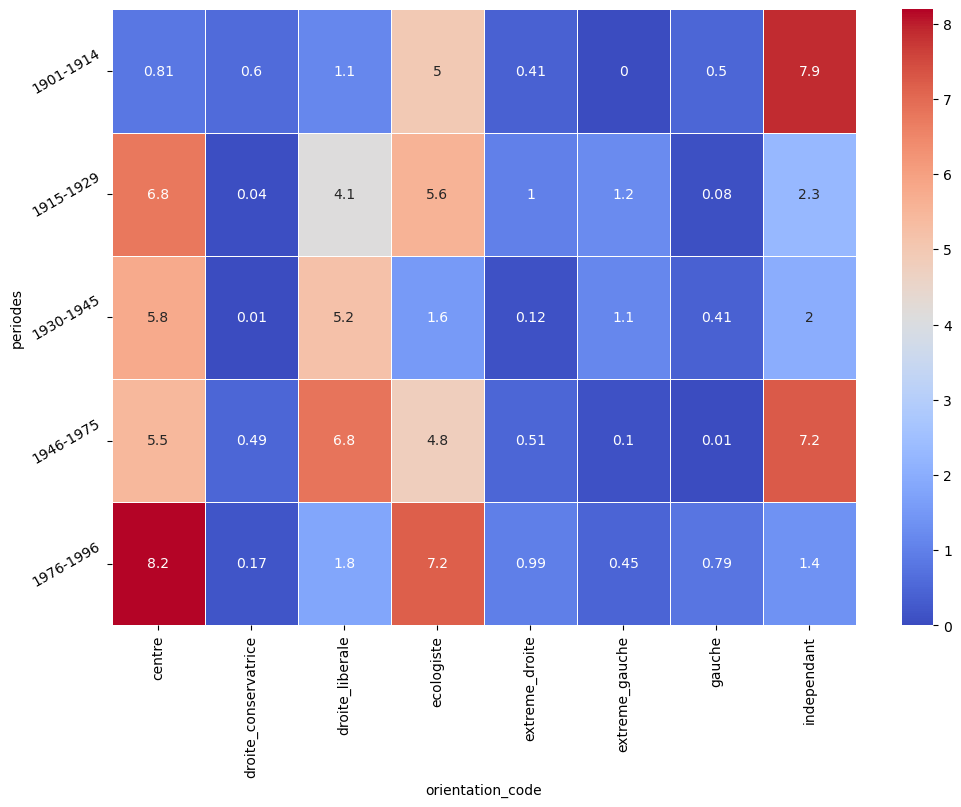

In [92]:
### Proportion des contributions au chi-2
tableau = rt.iloc[:-1,:-1]

fig, ax = plt.subplots(figsize=(12,8))         
# Sample figsize in inches
g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
labels = tableau.index
p = g.set_yticklabels(labels, rotation=30)

plt.show()

In [93]:
from fanalysis.ca import CA 
from fanalysis.mca import MCA

# genre et orientations politiques

In [94]:
X = "genre_code"
Y = "orientation_code"  # "0"

df_p_parti_genre = df_p[[Y,X]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int) 
df_p_parti_genre

orientation_code,centre,droite_conservatrice,droite_liberale,ecologiste,extreme_droite,extreme_gauche,gauche,independant,Total
genre_code,,,,,,,,,
F,53,3,26,36,17,3,70,2,210
M,270,19,75,29,165,6,141,25,730
Total,323,22,101,65,182,9,211,27,940


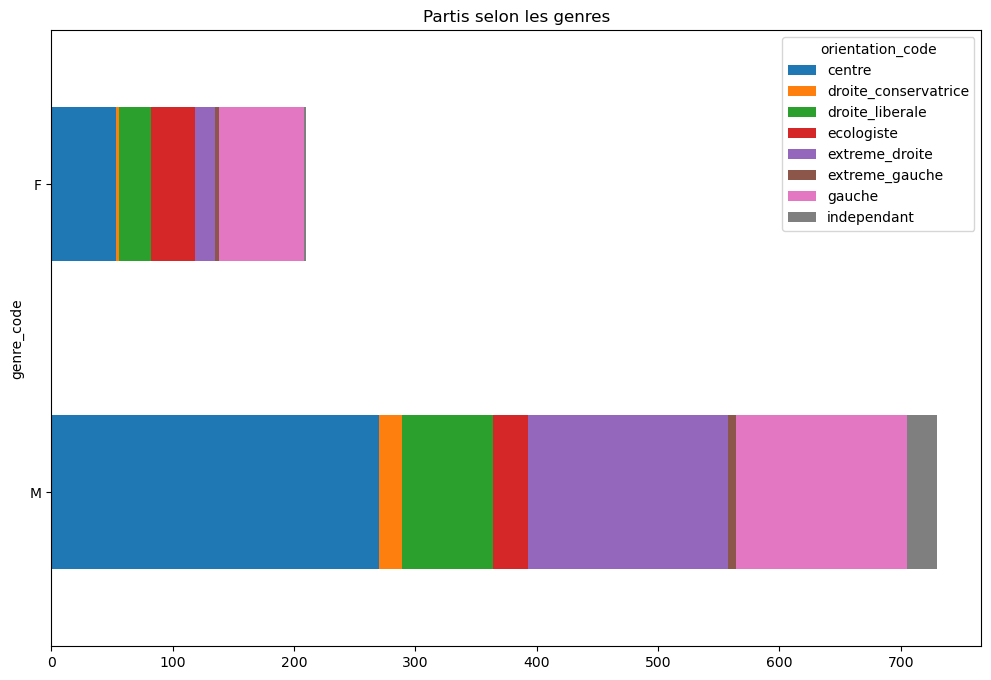

In [95]:
### Effectifs des partis selon le genre
g = df_p_parti_genre.iloc[:-1, :-1].sort_index(ascending=False)\
        .plot( kind='barh', stacked=True,  figsize=(12,8),  title = 'Partis selon les genres')


plt.show()

In [96]:
### pourcentages des lignes
stacked_data_lignes = df_p_parti_genre.apply(lambda x: (x*100/sum(x)*2).round(2), axis=1) # axis=0
stacked_data_lignes

orientation_code,centre,droite_conservatrice,droite_liberale,ecologiste,extreme_droite,extreme_gauche,gauche,independant,Total
genre_code,,,,,,,,,
F,25.24,1.43,12.38,17.14,8.10,1.43,33.33,0.95,100.0
M,36.99,2.60,10.27,3.97,22.60,0.82,19.32,3.42,100.0
Total,34.36,2.34,10.74,6.91,19.36,0.96,22.45,2.87,100.0


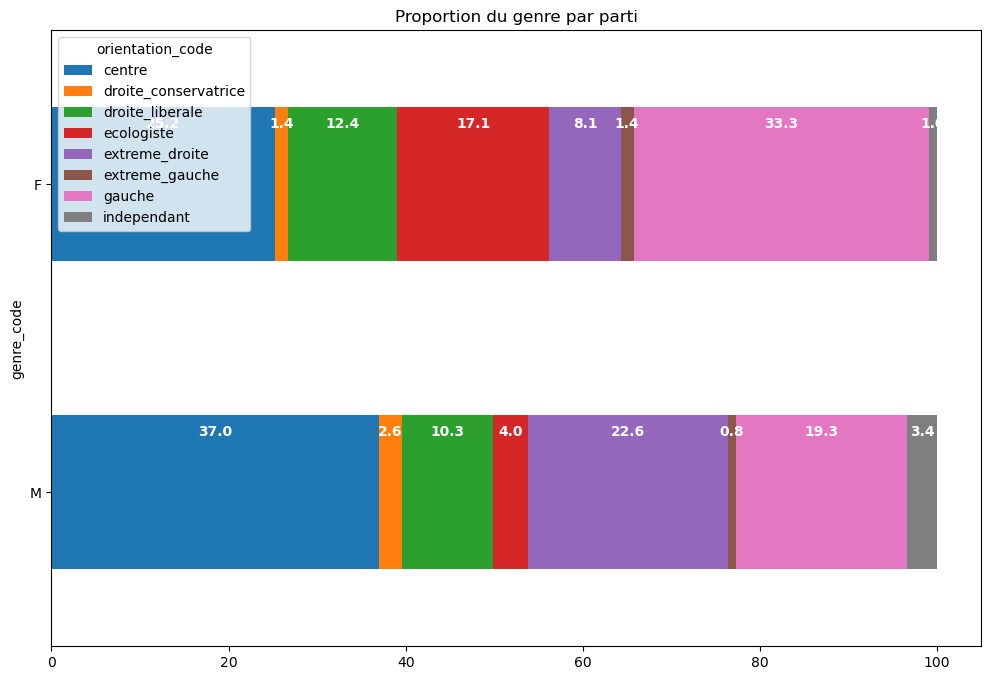

In [97]:
### https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

z = stacked_data_lignes.iloc[:-1, :-1].sort_index(ascending=False).plot(kind="barh", stacked=True, figsize=(12,8), title='Proportion du genre par parti')

### https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
#b = [(p.get_bbox().bounds, p.get_bbox().xmin,p.get_bbox().ymin, p.get_bbox().ymax, p.get_width(), p.get_y(), p.get_height()) for p in z.patches][59]
#print(b)
for p in z.patches:
    b = p.get_bbox()
    y_value=b.y1-b.y0
    z.annotate(format(p.get_width(), '.1f'), 
                   (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   # style = 'italic',
                   weight='bold',
                   color = 'white',
                   xytext = (0, -12), 
                   textcoords = 'offset points')

# Doc.: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('images/genre_par_parti.jpg', bbox_inches='tight',
                       pad_inches=0.2)

plt.show()

#### Calcul de la différence à l'indépendance

In [98]:
tx = df_p_parti_genre.loc[:,["Total"]]
ty = df_p_parti_genre.loc[["Total"],:]
n = df_p_parti_genre.iat[-1,-1]   # .iloc[:-1,:-1] 

### Compute the matrix multiplication between the columns.
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dot.html
indep = tx.dot(ty) / n
#pd.options.display.float_format = '{0:3.5}'.format

# Arrondi
display(indep.astype(int))


orientation_code,centre,droite_conservatrice,droite_liberale,ecologiste,extreme_droite,extreme_gauche,gauche,independant,Total
genre_code,,,,,,,,,
F,72,4,22,14,40,2,47,6,210
M,250,17,78,50,141,6,163,20,730
Total,323,22,101,65,182,9,211,27,940


In [99]:
### Différence en effectifs entre le théorique et l'observé
### Doc. :
#  https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4775616-analysez-deux-variables-qualitatives-avec-le-chi-2
ecarts = (df_p_parti_genre-indep)
## Attention : arrondi aux entiers dans l'affichage
display(ecarts.iloc[:-1,:-1].astype(int))

orientation_code,centre,droite_conservatrice,droite_liberale,ecologiste,extreme_droite,extreme_gauche,gauche,independant
genre_code,,,,,,,,
F,-19,-1,3,21,-23,0,22,-4
M,19,1,-3,-21,23,0,-22,4


In [100]:
def sign(val):
    
    if val > 0:
        a = 1
    elif val < 0:
        a = -1
    else:
        a = 0    
    return a


sign(-3)

-1

In [101]:
ecarts_signe = ecarts.iloc[:-1,:-1].applymap(sign)
ecarts_signe

C:\Users\LZender\AppData\Local\Temp\ipykernel_19120\2835276443.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ecarts_signe = ecarts.iloc[:-1,:-1].applymap(sign)


orientation_code,centre,droite_conservatrice,droite_liberale,ecologiste,extreme_droite,extreme_gauche,gauche,independant
genre_code,,,,,,,,
F,-1,-1,1,1,-1,1,1,-1
M,1,1,-1,-1,1,-1,-1,1


In [102]:
### Ecarts positifs et pondérés par les effectifs
### Doc. :
#  https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4775616-analysez-deux-variables-qualitatives-avec-le-chi-2
#  le chi2 : (valeur observée - valeur attendue)²/valeur attendue
ecarts_ponderes = ((df_p_parti_genre-indep)**2/indep).iloc[:-1,:-1]
ecarts_ponderes

orientation_code,centre,droite_conservatrice,droite_liberale,ecologiste,extreme_droite,extreme_gauche,gauche,independant
genre_code,,,,,,,,
F,5.087188,0.746062,0.523283,31.769628,13.767371,0.486829,11.087745,2.695054
M,1.463438,0.214621,0.150533,9.139208,3.960477,0.140047,3.189625,0.775290


In [103]:
ecarts_ponderes_signe = ecarts_ponderes * ecarts_signe
ecarts_ponderes_signe

orientation_code,centre,droite_conservatrice,droite_liberale,ecologiste,extreme_droite,extreme_gauche,gauche,independant
genre_code,,,,,,,,
F,-5.087188,-0.746062,0.523283,31.769628,-13.767371,0.486829,11.087745,-2.695054
M,1.463438,0.214621,-0.150533,-9.139208,3.960477,-0.140047,-3.189625,0.775290


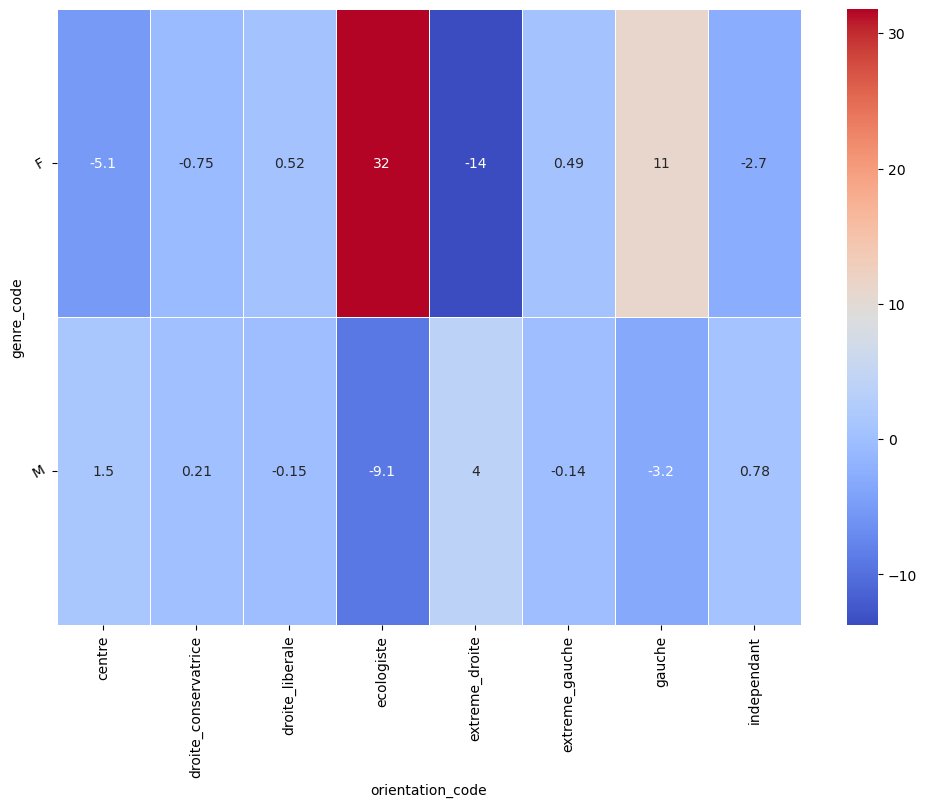

In [104]:
### Écart pondérés
tableau = ecarts_ponderes_signe

fig, ax = plt.subplots(figsize=(12,8))         
# Sample figsize in inches
g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
labels = tableau.index
p = g.set_yticklabels(labels, rotation=30)

# Doc.: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('images/partis_par_genre_écarts_pond.jpg', bbox_inches='tight',
                       pad_inches=0.2)

plt.show()

Chi carré : 85.196


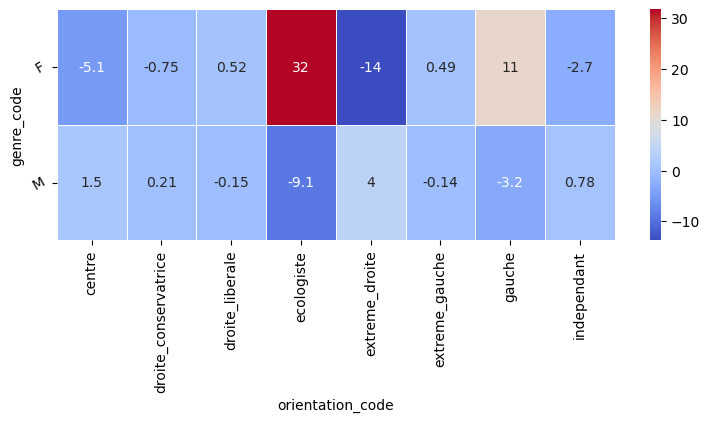

In [105]:
## Chi2 :somme des écarts pondérés

chi_2 = ecarts_ponderes.sum().sum() 
print('Chi carré :', round(chi_2,3))


fig, ax = plt.subplots(figsize=(9,3))         
# Sample figsize in inches
g = sns.heatmap(ecarts_ponderes_signe, annot=ecarts_ponderes_signe, cmap="coolwarm", linewidths=.5, ax=ax)
labels = ecarts_ponderes.index

p = g.set_yticklabels(labels, rotation=30)

plt.show()

In [106]:
### Degrés d'indépendance
print("Degrés d'indépendance :",(len(ecarts_ponderes_sign)-1) * (len(ecarts_ponderes_sign.columns)-1))

Degrés d'indépendance : 28


In [107]:
statistic, p, dof, expected = stats.chi2_contingency(df_p_parti_genre.iloc[:-1,:-1])

print(statistic, p, dof)

### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),1)
dfe

85.19639853775612 1.1949884544040229e-15 7


,0,1,2,3,4,5,6,7
0,72.2,4.9,22.6,14.5,40.7,2.0,47.1,6.0
1,250.8,17.1,78.4,50.5,141.3,7.0,163.9,21.0


In [108]:
### Probabilité de ce tromper si on rejette l'hypothèse d'indépendance:
# quasiment 0%
print("({0:.30f})".format(p))

(0.000000000000001194988454404023)


### Test statistique: rejet de l'hypothèse d'indépendance ? peine à comprendre cette cellule...

L'hypothèse d'indépendance H0 peut être rejetée:

* valeur critique pour 32 degrés de liberté, à 5 % (= 0.05), Bennani, p.277, tableau D2 = 9.488
   * cf. https://fr.wikipedia.org/wiki/Loi_du_%CF%87%C2%B2
   * https://fr.wikipedia.org/wiki/Test_du_%CF%87%C2%B2
   * [Test du khi-deux d'indépendance](https://www.jmp.com/fr_fr/statistics-knowledge-portal/chi-square-test/chi-square-test-of-independence.html)
   * https://www.statology.org/chi-square-distribution-table/
   * https://www.statology.org/chi-square-test-of-independence-python/
   
<br/>   

* chi-2 = 106.163

* P-value:  .... (cf. https://www.statology.org/chi-square-p-value-calculator/)

Le chi-2 est donc largement supérieur à la valeur critique à 5 % d'erreur, donc les variables ne sont pas indépendantes, H0 (hypothèse d'indépendance) peut être rejetée. Il y a un lien clair entre genre et orientation politique. 

On peut maintenant inspecter les spécificités:

In [109]:
### Tables des proportions de contributions au chi-2
# cf. Benani, p.35

table = ecarts_ponderes/chi_2
table['total'] = table.sum(axis=1)
table.loc['total'] = table.sum(axis=0)
table

orientation_code,centre,droite_conservatrice,droite_liberale,ecologiste,extreme_droite,extreme_gauche,gauche,independant,total
genre_code,,,,,,,,,
F,0.059711,0.008757,0.006142,0.372899,0.161596,0.005714,0.130143,0.031633,0.776596
M,0.017177,0.002519,0.001767,0.107272,0.046486,0.001644,0.037438,0.009100,0.223404
total,0.076889,0.011276,0.007909,0.480171,0.208082,0.007358,0.167582,0.040733,1.000000


In [110]:
### % plus lisibles
rt = round(table*100,2)

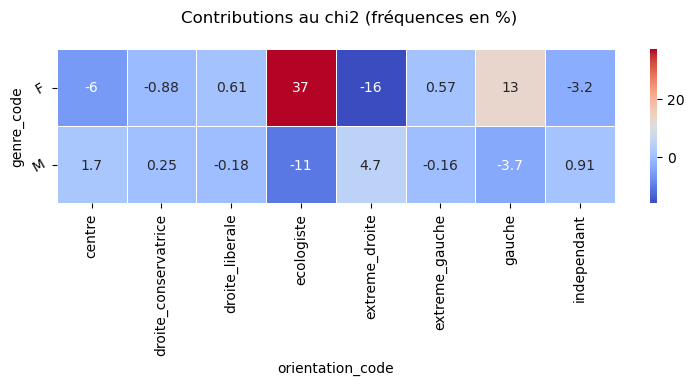

In [111]:
### Proportion des contributions au chi-2 avec signes

tableau = rt.iloc[:-1,:-1] * ecarts_signe

fig, ax = plt.subplots(figsize=(9,2))
fig.suptitle('Contributions au chi2 (fréquences en %)', y=1.08, x=0.45, size=12)
# Sample figsize in inches
g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax,)
labels = tableau.index
g.set_yticklabels(labels, rotation=30, size=10)

plt.show()